In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model

# define GPU id to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# import helpers
from src.utils.utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, get_samples
from src.utils.KerasCallbacks import get_callbacks
import src.utils.my_metrics as metr
import cv2


# define experiment name for report, model and log paths + filenames
#EXPERIMENT = '2D/tf2/acdc/combined/2D_NOrot90_dfsplit_6_224_11_fold1'
EXPERIMENT = '2D/ax_sax/gcn_and_acdc_exlusive_ax/'
now = datetime.datetime.now()
# image params, change for different input data/architecture
ARCHITECTURE = '2D' # 2D
# path params
DATASET = 'GCN'  # 'acdc' # or 'gcn'
TRAIN_PATH = 'data/raw/{}/{}/train/'.format(DATASET, ARCHITECTURE)
VAL_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
TEST_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
DF_DATA_PATH = 'data/raw/gcn_05_2020/SAx_3Ddf_kfold.csv'.format(DATASET, ARCHITECTURE)
#DF_DATA_PATH = 'data/raw/miccai2020/2d_dataset.csv' # miccai special case
DATA_PATH = '/mnt/data/git/cardio/data/raw/gcn_05_2020_sax_excl_ax_patients/2D/'
FOLD = 0

MODEL_PATH = os.path.join('models', EXPERIMENT, str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))

DIM = [224, 224] # network input params
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 48 # initial number of filters, will be doubled after each downsampling block
#SPACING = [8,1.1, 1,1] # used by sitk, order will be reversed to have the same shape as dim
SPACING = [1.5, 1.5] # if resample, resample to this spacing
M_POOL = [2, 2]# used for downsampling and upsampling
F_SIZE = [3, 3] # conv filter size
IMG_CHANNELS = 1
MASK_VALUES = [0, 1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.cv2.BORDER_CONSTANT
IMG_INTERPOLATION = cv2.INTER_LINEAR
MSK_INTERPOLATION = cv2.INTER_NEAREST
AUGMENT = True
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = False
SCALER = 'MinMax' # MinMax Standard or Robust

# training params
#GENERATOR_WORKER = 6# if not set, use batchsize
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 32 # 32, 64, 24, 16, 1 for 3D use: 8
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'val_dice_coef_labels'
MONITOR_MODE = 'max'
SAVE_MODEL_FUNCTION = 'val_dice_coef_labels'
SAVE_MODEL_MODE = 'max'
BN_FIRST = False # decide if BN between Conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose
PAD = 'same' # padding strategy
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu, any non linear activation function
LEARNING_RATE = 0.001 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]

LOSS_FUNCTION = metr.bce_dice_loss
#LOSS_FUNCTION = metr.jaccard_distance_loss
#LOSS_FUNCTION = metr.bce_dice_jac_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)

# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2020-07-23 17:19:18,586 INFO -------------------- Start --------------------
2020-07-23 17:19:18,587 INFO Working directory: /mnt/data/git/cardio.
2020-07-23 17:19:18,587 INFO Log file: ./logs/2D/ax_sax/gcn_and_acdc_exlusive_ax/.log
2020-07-23 17:19:18,587 INFO Log level for console: INFO


['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'EXPERIMENT': '2D/ax_sax/gcn_and_acdc_exlusive_ax/', 'ARCHITECTURE': '2D', 'DATASET': 'GCN', 'TRAIN_PATH': 'data/raw/GCN/2D/train/', 'VAL_PATH': 'data/raw/GCN/2D/val/', 'TEST_PATH': 'data/raw/GCN/2D/val/', 'DF_DATA_PATH': 'data/raw/gcn_05_2020/SAx_3Ddf_kfold.csv', 'DATA_PATH': '/mnt/data/git/cardio/data/raw/gcn_05_2020_sax_excl_ax_patients/2D/', 'FOLD': 0, 'MODEL_PATH': 'models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19', 'CONFIG_PATH': 'reports/configs/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19', 'HISTORY_PATH': 'reports/history/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19', 'DIM': [224, 224], 'DEPTH': 4, 'FILTERS': 48, 'SPACING': [1.5, 1.5], 'M_POOL': [2, 2], 'F_SIZE': [3, 3], 'IMG_CHANNELS': 1, 'MASK_VALUES': [0, 1, 2, 3], 'MASK_CLASSES': 4, 'BORDER_MODE': 0, 'IMG_INTERPOLATION': 1, 'MSK_

## Get training, val and test-files

In [23]:
from src.data.Dataset import get_kfolded_data
df = get_kfolded_data(kfolds=4, path_to_data='data/raw/gcn_05_2020_sax_excl_ax_patients/4D/')

2020-07-22 17:33:44,801 INFO found: 193 files
2020-07-22 17:33:44,802 INFO found: 193 patients


In [24]:
df.to_csv('data/raw/gcn_05_2020_sax_excl_ax_patients/df_4d.csv',index=False)

In [2]:
# used for training a model from scratch
info = {}

# 2D & 3D file or ACDC format
#x_train, y_train = get_img_msk_files_from_split_dir(config['TRAIN_PATH'])
#x_val, y_val = get_img_msk_files_from_split_dir(config['VAL_PATH'])
#x_test, y_test = get_img_msk_files_from_split_dir(config['TEST_PATH'])

# load files from df_folds dataframe
#x_train, y_train, x_val, y_val, info = get_train_data_from_df(first_df=config['DF_DATA_PATH'], second_df='reports/kfolds_data/2D/gcn/df_kfold.csv', n_second_df=25, n_first_df=0)
#x_train, y_train, x_val, y_val, info = get_train_data_from_df(first_df=config['DF_DATA_PATH'], fold=FOLD)
x_train, y_train, x_val, y_val =  get_trainings_files(data_path=DATA_PATH,fold=FOLD,path_to_folds_df='data/raw/gcn_05_2020_sax_excl_ax_patients/df_4d.csv')
x_train_, y_train_, x_val_, y_val_ =  get_trainings_files(data_path='data/raw/ACDC/2D/all/',fold=FOLD,path_to_folds_df='data/raw/ACDC/2D/df_kfold.csv')

x_train +=x_train_
y_train +=y_train_
x_val += x_val_ 
y_val += y_val_
# finetune specials
#_, _, x_val, y_val, info_ = get_train_data_from_df(firs_df='reports/kfolds_data/2D/gcn/df_kfold.csv')

config.update(info)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train), len(y_train)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val), len(y_val)))

2020-07-23 17:19:37,690 INFO Found 13330 images/masks in /mnt/data/git/cardio/data/raw/gcn_05_2020_sax_excl_ax_patients/2D/
2020-07-23 17:19:37,690 INFO Patients train: 144
2020-07-23 17:19:38,095 INFO Selected 9975 of 13330 files with 144 of 193 patients for training fold 0
2020-07-23 17:19:38,120 INFO Found 1902 images/masks in data/raw/ACDC/2D/all/
2020-07-23 17:19:38,120 INFO Patients train: 1426
2020-07-23 17:19:38,269 INFO Selected 1426 of 1902 files with 1426 of 100 patients for training fold 0
2020-07-23 17:19:38,270 INFO x_train files: 11401, y_train files: 11401
2020-07-23 17:19:38,270 INFO x_val files: 3831, y_val files: 3831


## Create Datagenerator

In [3]:
# create a batch generator
logging.getLogger().setLevel(logging.INFO)
batch_generator = DataGenerator(x_train, y_train, config=config)
val_config = config.copy()
val_config['AUGMENT_GRID'] = False# make sure no augmentation will be applied to the validation data
val_config['AUGMENT'] = False
validation_generator = DataGenerator(x_val, y_val , config=val_config)

2020-07-23 17:20:01,448 INFO Create DataGenerator
2020-07-23 17:20:01,495 INFO Datagenerator created with: 
 shape: [224, 224]
 spacing: [1.5, 1.5]
 batchsize: 32
 Scaler: MinMax
 Images: 11401 
 Augment_grid: False 
 Thread workers: 32
2020-07-23 17:20:01,496 INFO Data will be augmented (shift,scale and rotate) with albumentation
2020-07-23 17:20:01,496 INFO Create DataGenerator
2020-07-23 17:20:01,512 INFO Datagenerator created with: 
 shape: [224, 224]
 spacing: [1.5, 1.5]
 batchsize: 32
 Scaler: MinMax
 Images: 3831 
 Augment_grid: False 
 Thread workers: 32
2020-07-23 17:20:01,513 INFO No augmentation


## Visualize one batch

In [4]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(batch_generator), 1)):
    global x, y
    x, y = batch_generator.__getitem__(batch)
    print(x.shape)
    print('selected batch : ' + str(batch))

interactive(children=(IntSlider(value=178, description='batch', max=356), Output()), _dom_classes=('widget-int…

In [5]:
#from numpy import save
#root_folder = 'data/interim/acdc/2d_numpy/'
#for i, (x_2d, y_2d) in enumerate(zip(x,y)):
#    f_path = os.path.join(root_folder, '{}'.format(i))
#    save('{}{}'.format(f_path, '_x.npy'), x_2d)
#    save('{}{}'.format(f_path, '_y.npy'), y_2d)
    

In [6]:
@interact
def select_image_in_batch(im = (0,BATCHSIZE- 1, 1), slice_n=(1,11)):
    
    # logging level == debug --> visualise the generator steps
    print(x.shape, y.shape)
    show_2D_or_3D(x[im], y[im])
    plt.show()


interactive(children=(IntSlider(value=15, description='im', max=31), IntSlider(value=6, description='slice_n',…

In [31]:
@interact
def interact_load_pretrained_model(config_file=glob.glob('reports/configs/{}/acdc/finetune/**/*.json'.format(config.get('ARCHITECTURE', '2D')), recursive=False), load=False):
    """
    load past config for model training 
    """
    # load config with all params into global namespace
    from src.models.ModelUtils import load_pretrained_model
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config_temp = json.loads(data_file.read())
        config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
        logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
        #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    
        try:
            # load model
            globals()['model'] = load_pretrained_model(config_temp, metrics)
            model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=('reports/configs/2D/acdc/finetune/2019-10-0…

In [3]:
# Load a previous config and by this a pre-trained model
from ipyfilechooser import FileChooser
config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs'), 'config.json')
display(config_chooser)

FileChooser(path='/mnt/data/git/cardio/reports/configs', filename='config.json', show_hidden='False')

## Create Model

In [7]:
# Cell for automation of the model loading process
# load one basemodel for the finetuning task
"""
load past config for model training 
"""
if 'streategy' in locals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
load = False # change to false, if this pipeline is used without finetuning
# load config with all params into global namespace
from src.models.ModelUtils import load_pretrained_model
if load: # load pretrained model
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    try:
        with strategy.scope():
            globals()['model'] = load_pretrained_model(config_temp, metrics, comp=False,multigpu=False)
            model.summary()
    except Exception as e:
        logging.error(str(e))
        
else:
    pass
# distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
#from src.models.ModelManager_2d3d import get_model, create_comb_shared_unet, create_unet, create_3d_wrapper
#from src.models.ModelManager_2d3d import get_model, create_unet
import src.models.Unets as modelmanager
with strategy.scope():
    # create new model
    logging.info('Create model')
    #model = modelmanager.create_2d_3d_avg_model(config, metrics, supervision=False)
    model = modelmanager.create_unet(config, metrics, supervision=False)
    #model = modelmanager.create_stacked_unet(config, metrics, supervision=False, unet_2d=model)
    #model = modelmanager.create_stacked_unet_concat_input(config, metrics, supervision=False, unet_2d=model)
    #model = create_comb_shared_unet(config, metrics)
    #model = modelmanager.create_3d_wrapper_for_2d_unet(config=config, metrics=metrics, unet_2d=model)
    model.summary()

2020-07-23 17:20:20,663 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2020-07-23 17:20:20,677 INFO Create model


using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
(None, 224, 224, 1)


2020-07-23 17:20:21,037 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-07-23 17:20:21,040 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-07-23 17:20:21,047 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-07-23 17:20:21,050 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-07-23 17:20:21,065 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-07-23 17:20:21,068 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-07-23 17:20:21,105 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 48) 480         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 48) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [33]:
model.save(MODEL_PATH)

2020-07-22 17:34:57,860 WARNING From /home/sven/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:110: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-07-22 17:34:57,875 WARNING From /home/sven/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:110: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-07-22 17:35:01,769 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-22_17_33/assets


In [8]:
initial_epoch = 0
# training

# start a new main process for this training to free gpu memory afterwards
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator

results = model.fit(
    x=batch_generator,
    epochs=config['EPOCHS'],
    callbacks=get_callbacks(config, batch_generator, validation_generator),
    steps_per_epoch = len(batch_generator),
    validation_data=validation_generator,
    initial_epoch=initial_epoch,
    max_queue_size=20,
    workers=0,
    verbose=1)

2020-07-23 17:20:39,442 INFO Fit model, start trainings process
2020-07-23 17:20:39,816 WARNING From /home/sven/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Epoch 1/300


2020-07-23 17:20:41,668 INFO batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1
2020-07-23 17:20:44,452 INFO batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1


  1/356 [..............................] - ETA: 0s - loss: 0.1805 - dice_coef_labels: 0.0142 - dice_coef_myo: 0.0203 - dice_coef_lv: 0.0289 - dice_coef_rv: 0.0095

2020-07-23 17:20:51,978 WARNING From /home/sven/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


356/356 [==============================] - ETA: 0s - loss: -0.5314 - dice_coef_labels: 0.5403 - dice_coef_myo: 0.4735 - dice_coef_lv: 0.6281 - dice_coef_rv: 0.5761

2020-07-23 17:22:35,820 INFO Saved model to disk: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19



Epoch 00001: val_dice_coef_labels improved from -inf to 0.61712, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 17:22:38,762 WARNING From /home/sven/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:110: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-07-23 17:22:38,777 WARNING From /home/sven/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:110: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-07-23 17:22:43,256 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00001: val_dice_coef_labels improved from -inf to 0.61712, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 112s 314ms/step - loss: -0.5314 - dice_coef_labels: 0.5403 - dice_coef_myo: 0.4735 - dice_coef_lv: 0.6281 - dice_coef_rv: 0.5761 - val_loss: -0.6137 - val_dice_coef_labels: 0.6171 - val_dice_coef_myo: 0.5240 - val_dice_coef_lv: 0.7265 - val_dice_coef_rv: 0.6612 - lr: 0.0010
Epoch 2/300
356/356 [==============================] - ETA: 0s - loss: -0.7656 - dice_coef_labels: 0.7521 - dice_coef_myo: 0.6965 - dice_coef_lv: 0.8617 - dice_coef_rv: 0.7798
Epoch 00002: val_dice_coef_labels improved from 0.61712 to 0.74739, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 17:24:36,955 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00002: val_dice_coef_labels improved from 0.61712 to 0.74739, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 113s 318ms/step - loss: -0.7656 - dice_coef_labels: 0.7521 - dice_coef_myo: 0.6965 - dice_coef_lv: 0.8617 - dice_coef_rv: 0.7798 - val_loss: -0.7506 - val_dice_coef_labels: 0.7474 - val_dice_coef_myo: 0.7103 - val_dice_coef_lv: 0.8418 - val_dice_coef_rv: 0.7648 - lr: 0.0010
Epoch 3/300
356/356 [==============================] - ETA: 0s - loss: -0.8027 - dice_coef_labels: 0.7894 - dice_coef_myo: 0.7369 - dice_coef_lv: 0.8869 - dice_coef_rv: 0.8150
Epoch 00003: val_dice_coef_labels improved from 0.74739 to 0.78073, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 17:26:35,763 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00003: val_dice_coef_labels improved from 0.74739 to 0.78073, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 332ms/step - loss: -0.8027 - dice_coef_labels: 0.7894 - dice_coef_myo: 0.7369 - dice_coef_lv: 0.8869 - dice_coef_rv: 0.8150 - val_loss: -0.7823 - val_dice_coef_labels: 0.7807 - val_dice_coef_myo: 0.7357 - val_dice_coef_lv: 0.8584 - val_dice_coef_rv: 0.8030 - lr: 0.0010
Epoch 4/300
356/356 [==============================] - ETA: 0s - loss: -0.8230 - dice_coef_labels: 0.8110 - dice_coef_myo: 0.7567 - dice_coef_lv: 0.8988 - dice_coef_rv: 0.8375
Epoch 00004: val_dice_coef_labels improved from 0.78073 to 0.80829, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 17:28:37,185 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00004: val_dice_coef_labels improved from 0.78073 to 0.80829, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 121s 340ms/step - loss: -0.8230 - dice_coef_labels: 0.8110 - dice_coef_myo: 0.7567 - dice_coef_lv: 0.8988 - dice_coef_rv: 0.8375 - val_loss: -0.8104 - val_dice_coef_labels: 0.8083 - val_dice_coef_myo: 0.7647 - val_dice_coef_lv: 0.8792 - val_dice_coef_rv: 0.8288 - lr: 0.0010
Epoch 5/300
356/356 [==============================] - ETA: 0s - loss: -0.8330 - dice_coef_labels: 0.8215 - dice_coef_myo: 0.7658 - dice_coef_lv: 0.9034 - dice_coef_rv: 0.8490
Epoch 00005: val_dice_coef_labels improved from 0.80829 to 0.81037, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 17:30:38,226 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00005: val_dice_coef_labels improved from 0.80829 to 0.81037, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 121s 339ms/step - loss: -0.8330 - dice_coef_labels: 0.8215 - dice_coef_myo: 0.7658 - dice_coef_lv: 0.9034 - dice_coef_rv: 0.8490 - val_loss: -0.8161 - val_dice_coef_labels: 0.8104 - val_dice_coef_myo: 0.7497 - val_dice_coef_lv: 0.8862 - val_dice_coef_rv: 0.8384 - lr: 0.0010
Epoch 6/300
356/356 [==============================] - ETA: 0s - loss: -0.8487 - dice_coef_labels: 0.8371 - dice_coef_myo: 0.7790 - dice_coef_lv: 0.9145 - dice_coef_rv: 0.8655
Epoch 00006: val_dice_coef_labels improved from 0.81037 to 0.83712, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 17:32:37,079 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00006: val_dice_coef_labels improved from 0.81037 to 0.83712, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 332ms/step - loss: -0.8487 - dice_coef_labels: 0.8371 - dice_coef_myo: 0.7790 - dice_coef_lv: 0.9145 - dice_coef_rv: 0.8655 - val_loss: -0.8466 - val_dice_coef_labels: 0.8371 - val_dice_coef_myo: 0.7901 - val_dice_coef_lv: 0.9165 - val_dice_coef_rv: 0.8588 - lr: 0.0010
Epoch 7/300
356/356 [==============================] - ETA: 0s - loss: -0.8483 - dice_coef_labels: 0.8372 - dice_coef_myo: 0.7803 - dice_coef_lv: 0.9132 - dice_coef_rv: 0.8650
Epoch 00007: val_dice_coef_labels did not improve from 0.83712

Epoch 00007: val_dice_coef_labels did not improve from 0.83712
356/356 [==============================] - 112s 315ms/step - loss: -0.8483 - dice_coef_labels: 0.8372 - dice_coef_myo: 0.7803 - dice_coef_lv: 0.9132 - dice_coef_rv: 0.8650 - val_loss: -0.8391 - val_dice_coef_labels: 0.8327 - v

2020-07-23 17:36:32,660 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00008: val_dice_coef_labels improved from 0.83712 to 0.84229, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 123s 344ms/step - loss: -0.8543 - dice_coef_labels: 0.8438 - dice_coef_myo: 0.7871 - dice_coef_lv: 0.9158 - dice_coef_rv: 0.8715 - val_loss: -0.8509 - val_dice_coef_labels: 0.8423 - val_dice_coef_myo: 0.7867 - val_dice_coef_lv: 0.9149 - val_dice_coef_rv: 0.8672 - lr: 0.0010
Epoch 9/300
356/356 [==============================] - ETA: 0s - loss: -0.8581 - dice_coef_labels: 0.8481 - dice_coef_myo: 0.7892 - dice_coef_lv: 0.9170 - dice_coef_rv: 0.8773
Epoch 00009: val_dice_coef_labels did not improve from 0.84229

Epoch 00009: val_dice_coef_labels did not improve from 0.84229
356/356 [==============================] - 112s 315ms/step - loss: -0.8581 - dice_coef_labels: 0.8481 - dice_coef_myo: 0.7892 - dice_coef_lv: 0.9170 - dice_coef_rv: 0.8773 - val_loss: -0.8442 - val_dice_coef_labels: 0.8402 - v

2020-07-23 17:40:27,535 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00010: val_dice_coef_labels improved from 0.84229 to 0.85711, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 122s 343ms/step - loss: -0.8626 - dice_coef_labels: 0.8522 - dice_coef_myo: 0.7942 - dice_coef_lv: 0.9205 - dice_coef_rv: 0.8809 - val_loss: -0.8641 - val_dice_coef_labels: 0.8571 - val_dice_coef_myo: 0.8089 - val_dice_coef_lv: 0.9219 - val_dice_coef_rv: 0.8803 - lr: 0.0010
Epoch 11/300
356/356 [==============================] - ETA: 0s - loss: -0.8657 - dice_coef_labels: 0.8548 - dice_coef_myo: 0.7963 - dice_coef_lv: 0.9237 - dice_coef_rv: 0.8838
Epoch 00011: val_dice_coef_labels did not improve from 0.85711

Epoch 00011: val_dice_coef_labels did not improve from 0.85711
356/356 [==============================] - 110s 308ms/step - loss: -0.8657 - dice_coef_labels: 0.8548 - dice_coef_myo: 0.7963 - dice_coef_lv: 0.9237 - dice_coef_rv: 0.8838 - val_loss: -0.8144 - val_dice_coef_labels: 0.8132 - 

2020-07-23 17:46:06,851 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00013: val_dice_coef_labels improved from 0.85711 to 0.86441, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 331ms/step - loss: -0.8696 - dice_coef_labels: 0.8591 - dice_coef_myo: 0.8021 - dice_coef_lv: 0.9260 - dice_coef_rv: 0.8872 - val_loss: -0.8708 - val_dice_coef_labels: 0.8644 - val_dice_coef_myo: 0.8193 - val_dice_coef_lv: 0.9245 - val_dice_coef_rv: 0.8869 - lr: 0.0010
Epoch 14/300
356/356 [==============================] - ETA: 0s - loss: -0.8720 - dice_coef_labels: 0.8614 - dice_coef_myo: 0.8026 - dice_coef_lv: 0.9277 - dice_coef_rv: 0.8904
Epoch 00014: val_dice_coef_labels did not improve from 0.86441

Epoch 00014: val_dice_coef_labels did not improve from 0.86441
356/356 [==============================] - 110s 308ms/step - loss: -0.8720 - dice_coef_labels: 0.8614 - dice_coef_myo: 0.8026 - dice_coef_lv: 0.9277 - dice_coef_rv: 0.8904 - val_loss: -0.8561 - val_dice_coef_labels: 0.8517 - 

2020-07-23 17:57:19,031 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00019: val_dice_coef_labels improved from 0.86441 to 0.87342, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 331ms/step - loss: -0.8834 - dice_coef_labels: 0.8734 - dice_coef_myo: 0.8163 - dice_coef_lv: 0.9339 - dice_coef_rv: 0.9013 - val_loss: -0.8810 - val_dice_coef_labels: 0.8734 - val_dice_coef_myo: 0.8289 - val_dice_coef_lv: 0.9325 - val_dice_coef_rv: 0.8947 - lr: 3.0000e-04
Epoch 20/300
356/356 [==============================] - ETA: 0s - loss: -0.8862 - dice_coef_labels: 0.8763 - dice_coef_myo: 0.8188 - dice_coef_lv: 0.9356 - dice_coef_rv: 0.9045
Epoch 00020: val_dice_coef_labels improved from 0.87342 to 0.87376, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 17:59:17,086 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00020: val_dice_coef_labels improved from 0.87342 to 0.87376, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 330ms/step - loss: -0.8862 - dice_coef_labels: 0.8763 - dice_coef_myo: 0.8188 - dice_coef_lv: 0.9356 - dice_coef_rv: 0.9045 - val_loss: -0.8813 - val_dice_coef_labels: 0.8738 - val_dice_coef_myo: 0.8266 - val_dice_coef_lv: 0.9330 - val_dice_coef_rv: 0.8962 - lr: 3.0000e-04
Epoch 21/300
356/356 [==============================] - ETA: 0s - loss: -0.8870 - dice_coef_labels: 0.8765 - dice_coef_myo: 0.8200 - dice_coef_lv: 0.9375 - dice_coef_rv: 0.9042
Epoch 00021: val_dice_coef_labels did not improve from 0.87376

Epoch 00021: val_dice_coef_labels did not improve from 0.87376
356/356 [==============================] - 110s 308ms/step - loss: -0.8870 - dice_coef_labels: 0.8765 - dice_coef_myo: 0.8200 - dice_coef_lv: 0.9375 - dice_coef_rv: 0.9042 - val_loss: -0.8732 - val_dice_coef_labels: 0.872

2020-07-23 18:03:06,483 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00022: val_dice_coef_labels improved from 0.87376 to 0.87618, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 119s 333ms/step - loss: -0.8887 - dice_coef_labels: 0.8789 - dice_coef_myo: 0.8218 - dice_coef_lv: 0.9374 - dice_coef_rv: 0.9069 - val_loss: -0.8829 - val_dice_coef_labels: 0.8762 - val_dice_coef_myo: 0.8259 - val_dice_coef_lv: 0.9328 - val_dice_coef_rv: 0.8998 - lr: 3.0000e-04
Epoch 23/300
356/356 [==============================] - ETA: 0s - loss: -0.8891 - dice_coef_labels: 0.8794 - dice_coef_myo: 0.8225 - dice_coef_lv: 0.9372 - dice_coef_rv: 0.9073
Epoch 00023: val_dice_coef_labels did not improve from 0.87618

Epoch 00023: val_dice_coef_labels did not improve from 0.87618
356/356 [==============================] - 110s 308ms/step - loss: -0.8891 - dice_coef_labels: 0.8794 - dice_coef_myo: 0.8225 - dice_coef_lv: 0.9372 - dice_coef_rv: 0.9073 - val_loss: -0.8770 - val_dice_coef_labels: 0.874

2020-07-23 18:10:37,309 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00026: val_dice_coef_labels improved from 0.87618 to 0.88038, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 331ms/step - loss: -0.8908 - dice_coef_labels: 0.8812 - dice_coef_myo: 0.8232 - dice_coef_lv: 0.9380 - dice_coef_rv: 0.9097 - val_loss: -0.8769 - val_dice_coef_labels: 0.8804 - val_dice_coef_myo: 0.8348 - val_dice_coef_lv: 0.9019 - val_dice_coef_rv: 0.9029 - lr: 3.0000e-04
Epoch 27/300
356/356 [==============================] - ETA: 0s - loss: -0.8921 - dice_coef_labels: 0.8823 - dice_coef_myo: 0.8251 - dice_coef_lv: 0.9398 - dice_coef_rv: 0.9105
Epoch 00027: val_dice_coef_labels did not improve from 0.88038

Epoch 00027: val_dice_coef_labels did not improve from 0.88038
356/356 [==============================] - 110s 308ms/step - loss: -0.8921 - dice_coef_labels: 0.8823 - dice_coef_myo: 0.8251 - dice_coef_lv: 0.9398 - dice_coef_rv: 0.9105 - val_loss: -0.8841 - val_dice_coef_labels: 0.878

2020-07-23 18:21:49,806 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00032: val_dice_coef_labels improved from 0.88038 to 0.88242, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 331ms/step - loss: -0.8946 - dice_coef_labels: 0.8847 - dice_coef_myo: 0.8286 - dice_coef_lv: 0.9412 - dice_coef_rv: 0.9124 - val_loss: -0.8862 - val_dice_coef_labels: 0.8824 - val_dice_coef_myo: 0.8371 - val_dice_coef_lv: 0.9268 - val_dice_coef_rv: 0.9045 - lr: 9.0000e-05
Epoch 33/300
356/356 [==============================] - ETA: 0s - loss: -0.8961 - dice_coef_labels: 0.8864 - dice_coef_myo: 0.8295 - dice_coef_lv: 0.9421 - dice_coef_rv: 0.9145
Epoch 00033: val_dice_coef_labels improved from 0.88242 to 0.88310, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/


2020-07-23 18:23:48,137 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00033: val_dice_coef_labels improved from 0.88242 to 0.88310, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 331ms/step - loss: -0.8961 - dice_coef_labels: 0.8864 - dice_coef_myo: 0.8295 - dice_coef_lv: 0.9421 - dice_coef_rv: 0.9145 - val_loss: -0.8863 - val_dice_coef_labels: 0.8831 - val_dice_coef_myo: 0.8366 - val_dice_coef_lv: 0.9255 - val_dice_coef_rv: 0.9057 - lr: 9.0000e-05
Epoch 34/300
356/356 [==============================] - ETA: 0s - loss: -0.8979 - dice_coef_labels: 0.8884 - dice_coef_myo: 0.8309 - dice_coef_lv: 0.9429 - dice_coef_rv: 0.9166
Epoch 00034: val_dice_coef_labels did not improve from 0.88310

Epoch 00034: val_dice_coef_labels did not improve from 0.88310
356/356 [==============================] - 110s 309ms/step - loss: -0.8979 - dice_coef_labels: 0.8884 - dice_coef_myo: 0.8309 - dice_coef_lv: 0.9429 - dice_coef_rv: 0.9166 - val_loss: -0.8902 - val_dice_coef_labels: 0.883

2020-07-23 18:31:19,356 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00037: val_dice_coef_labels improved from 0.88310 to 0.88331, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 332ms/step - loss: -0.8973 - dice_coef_labels: 0.8880 - dice_coef_myo: 0.8308 - dice_coef_lv: 0.9425 - dice_coef_rv: 0.9161 - val_loss: -0.8902 - val_dice_coef_labels: 0.8833 - val_dice_coef_myo: 0.8357 - val_dice_coef_lv: 0.9378 - val_dice_coef_rv: 0.9061 - lr: 9.0000e-05
Epoch 38/300
356/356 [==============================] - ETA: 0s - loss: -0.8978 - dice_coef_labels: 0.8883 - dice_coef_myo: 0.8310 - dice_coef_lv: 0.9428 - dice_coef_rv: 0.9166
Epoch 00038: val_dice_coef_labels did not improve from 0.88331

Epoch 00038: val_dice_coef_labels did not improve from 0.88331
356/356 [==============================] - 110s 309ms/step - loss: -0.8978 - dice_coef_labels: 0.8883 - dice_coef_myo: 0.8310 - dice_coef_lv: 0.9428 - dice_coef_rv: 0.9166 - val_loss: -0.8893 - val_dice_coef_labels: 0.882

2020-07-23 18:35:08,565 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00039: val_dice_coef_labels improved from 0.88331 to 0.88346, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 333ms/step - loss: -0.8978 - dice_coef_labels: 0.8887 - dice_coef_myo: 0.8313 - dice_coef_lv: 0.9421 - dice_coef_rv: 0.9169 - val_loss: -0.8906 - val_dice_coef_labels: 0.8835 - val_dice_coef_myo: 0.8368 - val_dice_coef_lv: 0.9384 - val_dice_coef_rv: 0.9058 - lr: 9.0000e-05
Epoch 40/300
356/356 [==============================] - ETA: 0s - loss: -0.8978 - dice_coef_labels: 0.8883 - dice_coef_myo: 0.8314 - dice_coef_lv: 0.9427 - dice_coef_rv: 0.9164
Epoch 00040: val_dice_coef_labels did not improve from 0.88346

Epoch 00040: val_dice_coef_labels did not improve from 0.88346
356/356 [==============================] - 110s 309ms/step - loss: -0.8978 - dice_coef_labels: 0.8883 - dice_coef_myo: 0.8314 - dice_coef_lv: 0.9427 - dice_coef_rv: 0.9164 - val_loss: -0.8881 - val_dice_coef_labels: 0.882

2020-07-23 18:40:49,055 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00042: val_dice_coef_labels improved from 0.88346 to 0.88421, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 332ms/step - loss: -0.8990 - dice_coef_labels: 0.8894 - dice_coef_myo: 0.8330 - dice_coef_lv: 0.9437 - dice_coef_rv: 0.9173 - val_loss: -0.8905 - val_dice_coef_labels: 0.8842 - val_dice_coef_myo: 0.8370 - val_dice_coef_lv: 0.9375 - val_dice_coef_rv: 0.9069 - lr: 9.0000e-05
Epoch 43/300
356/356 [==============================] - ETA: 0s - loss: -0.8989 - dice_coef_labels: 0.8895 - dice_coef_myo: 0.8323 - dice_coef_lv: 0.9434 - dice_coef_rv: 0.9177
Epoch 00043: val_dice_coef_labels did not improve from 0.88421

Epoch 00043: val_dice_coef_labels did not improve from 0.88421
356/356 [==============================] - 110s 309ms/step - loss: -0.8989 - dice_coef_labels: 0.8895 - dice_coef_myo: 0.8323 - dice_coef_lv: 0.9434 - dice_coef_rv: 0.9177 - val_loss: -0.8911 - val_dice_coef_labels: 0.884

2020-07-23 18:59:27,357 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00052: val_dice_coef_labels improved from 0.88421 to 0.88453, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 332ms/step - loss: -0.9007 - dice_coef_labels: 0.8915 - dice_coef_myo: 0.8345 - dice_coef_lv: 0.9441 - dice_coef_rv: 0.9194 - val_loss: -0.8911 - val_dice_coef_labels: 0.8845 - val_dice_coef_myo: 0.8356 - val_dice_coef_lv: 0.9379 - val_dice_coef_rv: 0.9076 - lr: 2.7000e-05
Epoch 53/300
356/356 [==============================] - ETA: 0s - loss: -0.9010 - dice_coef_labels: 0.8917 - dice_coef_myo: 0.8351 - dice_coef_lv: 0.9446 - dice_coef_rv: 0.9196
Epoch 00053: val_dice_coef_labels did not improve from 0.88453

Epoch 00053: val_dice_coef_labels did not improve from 0.88453
356/356 [==============================] - 110s 309ms/step - loss: -0.9010 - dice_coef_labels: 0.8917 - dice_coef_myo: 0.8351 - dice_coef_lv: 0.9446 - dice_coef_rv: 0.9196 - val_loss: -0.8898 - val_dice_coef_labels: 0.883

2020-07-23 19:14:23,678 INFO Assets written to: models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/assets



Epoch 00060: val_dice_coef_labels improved from 0.88453 to 0.88496, saving model to models/2D/ax_sax/gcn_and_acdc_exlusive_ax/2020-07-23_17_19/model.h5
356/356 [==============================] - 118s 332ms/step - loss: -0.9012 - dice_coef_labels: 0.8918 - dice_coef_myo: 0.8352 - dice_coef_lv: 0.9447 - dice_coef_rv: 0.9198 - val_loss: -0.8916 - val_dice_coef_labels: 0.8850 - val_dice_coef_myo: 0.8370 - val_dice_coef_lv: 0.9386 - val_dice_coef_rv: 0.9082 - lr: 8.1000e-06
Epoch 61/300
356/356 [==============================] - ETA: 0s - loss: -0.9008 - dice_coef_labels: 0.8914 - dice_coef_myo: 0.8341 - dice_coef_lv: 0.9447 - dice_coef_rv: 0.9197
Epoch 00061: val_dice_coef_labels did not improve from 0.88496

Epoch 00061: val_dice_coef_labels did not improve from 0.88496
356/356 [==============================] - 110s 310ms/step - loss: -0.9008 - dice_coef_labels: 0.8914 - dice_coef_myo: 0.8341 - dice_coef_lv: 0.9447 - dice_coef_rv: 0.9197 - val_loss: -0.8904 - val_dice_coef_labels: 0.883

## Write trainings history to disk

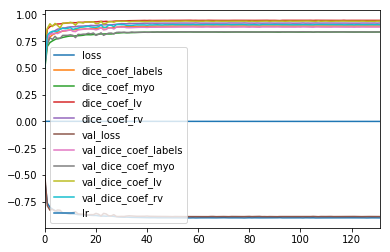

In [35]:
#logging.info(results.history)
df_history = pd.DataFrame(results.history)
df_history.plot()

In [ ]:
# run all cells for training, this cell will terminate the current jupyter process 
# --> free all ressources after the training has finished
os.system('kill %d' % os.getpid())

In [14]:
config['MODEL_PATH']

'models/3D/wrapper/gcn2nd/fold1/2020-06-27_11_24'

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [15]:

# serialize model to JSON
model_json = model.to_json()
with open(os.path.join(config['MODEL_PATH'], 'model.json'), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(config['MODEL_PATH'],'checkpoint.h5'))